
# Notebook version of DP_GP_cluster.py
- Created on: 242802
- Last modified: 242902

In [1]:
import matplotlib.pyplot as plt

from DP_GP import plot as dp_plt
from DP_GP import utils
from DP_GP import core
from DP_GP import cluster_tools

import pandas as pd
import numpy as np
import numpy.linalg as nl
import scipy
import GPy

# import standard library dependencies:
import collections
import time
import copy
import argparse
import os

## Input arguments

In [2]:
# list of count matrice(s) filepath
gene_expression_matrix = ['../../data/unstim_WT_counts_df_sample.txt']
# filepath to save the results
output_path_prefix = '../../data/' 

## Optional sampling Arguments
# Maximum number of Gibbs sampling iterations. default=1000
max_num_iterations = 1000
# Take every sth sample during Gibbs iterations to ensure independence between samples. default=3
# thinning_param
s = 3
# Specify the optimization technique used to update GP hyperparameters
# lbfgsb = L-BFGS-B 
# fmin_tnc = truncated Newton algorithm 
# simplex = Nelder-Mead simplex 
# scg = stochastic conjugate gradient 
# default = 'lbfgsb'
optimizer = 'lbfgsb'
# default=1000
max_iters = 1000
alpha = 1
m = 4
num_empty_clusters = 4
fast = False
check_convergence = False
check_burnin_convergence = False
sparse_regression = False
criterion = 'MAP'

### Optional hyperprior arguments

In [3]:
# sigma_n2_shape is shape parameter for the inverse gamma prior on the cluster noise variance. default=12
sigma_n2_shape = 12
# sigma_n2_rate is rate parameter for the inverse gamma prior on the cluster noise variance. default=2
sigma_n2_rate = 2
# for length scale [default=0]
length_scale_mu = 0
# for length scale [default=1]
length_scale_sigma = 1
# for signal variance [default=0]
sigma_f_mu = 0
# for signal variance [default=1]
sigma_f_sigma = 1

### Optional post-processing arguments

In [4]:
post_process = False
sim_mat = None

### Optional output arguments

In [5]:
plot = True
plot_types = ['pdf']
time_unit = None
save_cluster_GPs = False
save_residuals = False
do_not_plot_sim_mat = False
cluster_uncertainty_estimate = False

## Reading the count matrix

In [6]:
## Optional input transformation arguments

# Set this flag if the header contains true time values (e.g. 0, 0.5, 4, 8,...)
# and it is desired that the covariance kernel recognizes the true
# time spacing between sampling points, which need not be constant.
# Otherwise, it is assumed that the sampling times are equally spaced, 
# or in other words, that the rate of change in expression is roughly equivalent
# between all neighboring time points.
# default=False
true_times = False 

# Set this flag if you desire the gene expression data to be clustered
# without scaling (do not divide by standard deviation).
# default=False
unscaled = False

#Set this flag if you desire the gene expression data to be clustered
#without mean-centering (do not subtract mean).
#default=False
do_not_mean_center = False

In [7]:
gene_expression_matrix, gene_names, t, t_labels = \
core.read_gene_expression_matrices(gene_expression_matrix, 
                                   true_times, 
                                   unscaled, 
                                   do_not_mean_center)

In [8]:
# take median of inverse gamma distribution to yield point
# estimate of sigma_n
sigma_n2_shape, sigma_n2_rate = sigma_n2_shape, sigma_n2_rate
sigma_n = np.sqrt(1 / ((sigma_n2_shape + 1) * sigma_n2_rate))

# scale t such that the mean time interval between sampling points is one unit
# this ensures that initial parameters for length-scale and signal variance are reasonable
t /= np.mean(np.diff(t))

## Define global variables

In [9]:
# first phase of burn-in, expression trajectories cluster under initial length-scale and sigma_n parameters.
burnIn_phaseI = int(np.floor(max_num_iterations/5) * 1.2)
# second phase of burn-in, clusters optimize their hyperparameters.
burnIn_phaseII = burnIn_phaseI * 2 
# after burnIn_phaseII, samples are taken from the posterior

# epsilon for similarity matrix squared distance convergence
# and  epsilon for posterior log likelihood convergence
# only used if --check_convergence
sq_dist_eps, post_eps  = 0.01, 1e-5

## Run Gibbs Sampler

In [10]:
if not post_process:
    print("Begin sampling")
    GS = core.gibbs_sampler(gene_expression_matrix,t, max_num_iterations, max_iters, \
                            optimizer, burnIn_phaseI, burnIn_phaseII, alpha, m, \
                            s, check_convergence, check_burnin_convergence, sparse_regression, fast, \
                            sigma_n, sigma_n2_shape, sigma_n2_rate, \
                            length_scale_mu, length_scale_sigma, sigma_f_mu, \
                            sigma_f_sigma, sq_dist_eps, post_eps)
    sim_mat, all_clusterings, sampled_clusterings, log_likelihoods, iter_num = GS.sampler()
    
    sampled_clusterings.columns = gene_names
    all_clusterings.columns = gene_names
else:
    iter_num = 0

Begin sampling
Initializing one-gene clusters...
Sizes of clusters = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
Sizes of clusters = [1, 1, 6, 4, 1, 7, 0, 0, 0, 0]
Sizes of clusters = [1, 8, 7, 1, 3, 0, 0, 0, 0]
Sizes of clusters = [6, 8, 6, 0, 0, 0, 0]
Sizes of clusters = [6, 8, 3, 0, 0, 0, 0, 3]
Sizes of clusters = [9, 7, 1, 0, 0, 0, 0, 3]
Sizes of clusters = [9, 4, 0, 0, 0, 0, 6, 1]
Sizes of clusters = [9, 0, 0, 0, 0, 9, 2]
Sizes of clusters = [5, 0, 0, 0, 0, 14, 1]
Gibbs sampling iteration 10
Sizes of clusters = [5, 0, 0, 0, 0, 15]
Sizes of clusters = [4, 0, 0, 0, 0, 16]
Sizes of clusters = [3, 0, 0, 0, 0, 16, 1]
Sizes of clusters = [1, 0, 0, 0, 0, 17, 1, 1]
Sizes of clusters = [0, 0, 0, 0, 16, 1, 3]
Sizes of clusters = [0, 0, 0, 0, 9, 1, 10]
Sizes of clusters = [0, 0, 0, 0, 3, 17]
Sizes of clusters = [0, 0, 0, 0, 20]
Sizes of clusters = [0, 0, 0, 0, 20]
Sizes of clusters = [0, 0, 0, 0, 20]
Gibbs sampling iteration 20
Sizes of clusters = [0, 0, 0, 0, 19

## Find optimal clustering

In [11]:
if criterion == 'MPEAR':
    optimal_clusters = cluster_tools.best_clustering_by_mpear(np.array(sampled_clusterings), sim_mat)
elif criterion == 'MAP':
    optimal_clusters = cluster_tools.best_clustering_by_log_likelihood(np.array(sampled_clusterings), log_likelihoods)
elif criterion == 'least_squares':
    optimal_clusters = cluster_tools.best_clustering_by_sq_dist(np.array(sampled_clusterings), sim_mat)
elif criterion == 'h_clust_avg':
    optimal_clusters = cluster_tools.best_clustering_by_h_clust(sim_mat, 'average')
elif criterion == 'h_clust_comp':
    optimal_clusters = cluster_tools.best_clustering_by_h_clust(sim_mat, 'complete')

# Given an optimal clustering, optimize the hyperparameters once again
# because (1) hyperparameters are re-written at every iteration and (2) the particular clustering
# may never have actually occurred during sampling, as may happen for h_clust_avg/h_clust_comp.

optimal_cluster_labels = collections.defaultdict(list)
optimal_cluster_labels_original_gene_names = collections.defaultdict(list)
for gene, (gene_name, cluster) in enumerate(zip(gene_names, optimal_clusters)):
    optimal_cluster_labels[cluster].append(gene)
    optimal_cluster_labels_original_gene_names[cluster].append(gene_name)

if cluster_uncertainty_estimate:
    gene_to_prob = {}
    for gene_i_k, (gene_name, cluster) in enumerate(zip(gene_names, optimal_clusters)):
        genes_in_cluster = set(optimal_cluster_labels[cluster])
        genes_j_k = genes_in_cluster - set([gene_i_k])
        if len(genes_j_k) > 0:
            gene_to_prob[gene_name] = sum([sim_mat[gene_i_k,gene_j_k] for gene_j_k in genes_j_k])/len(genes_j_k)
        else:
            gene_to_prob[gene_name] = 1.
            

if cluster_uncertainty_estimate:
    print("Estimating cluster probability for each gene, loop:", end=' ')
    uncertainty_converged,last_gene_to_prob,prob_eps_cutoff,c,c_max=False,False,1e-8,0,200
    while uncertainty_converged == False:
        print(c, end=' ')
        gene_to_prob = {}
        for gene_i_k, (gene_name, cluster) in enumerate(zip(gene_names, optimal_clusters)):
            genes_in_cluster = set(optimal_cluster_labels[cluster])
            genes_j_k = genes_in_cluster - set([gene_i_k])
            if len(genes_j_k) > 0:
                if last_gene_to_prob is False:
                    # first loop through iterative process estimates the
                    # probability that gene belongs to cluster by taking
                    # the mean proportion of times gene co-clusters
                    # with every other gene in cluster
                    denominator = len(genes_j_k)
                    gene_to_prob[gene_i_k] = sum([sim_mat[gene_i_k,gene_j_k] for gene_j_k in genes_j_k])/denominator
                else:
                    # in subsequent loops, genes are weighted by how
                    # likely they are to belong to a cluster. In this way,
                    # the likelihood that a gene i belongs to cluster k 
                    # depends less on a gene j that is unlikely to belong to cluster k
                    # and depends more on gene l that is likely to belong to cluster k
                    denominator = sum([last_gene_to_prob[gene_j_k] for gene_j_k in genes_j_k])
                    gene_to_prob[gene_i_k] = sum([sim_mat[gene_i_k,gene_j_k] * last_gene_to_prob[gene_j_k] for gene_j_k in genes_j_k])/denominator
            else:
                gene_to_prob[gene_i_k] = 1.
                
        if last_gene_to_prob is not False:
            # find overall sum in absolute change in probability estimates
            prob_eps = sum([np.abs(gene_to_prob[g] - last_gene_to_prob[g]) for g in sorted(gene_to_prob)])    
            # check for convergence
            if prob_eps < prob_eps_cutoff:
                print("converged")
                for gene_i_k, gene_name in enumerate(gene_names):
                    gene_to_prob[gene_name] = gene_to_prob[gene_i_k]
                    del gene_to_prob[gene_i_k]
                    
                break
        
        last_gene_to_prob = gene_to_prob.copy()
        c+=1
        if c > c_max:
            print("WARNING: iterative cluster_uncertainty_estimate did not converge")
            for gene_i_k, gene_name in enumerate(zip(gene_names)):
                gene_to_prob[gene_name] = "NA"
            break

if save_residuals:
    name_d = {gene:gene_name for gene, gene_name in enumerate(gene_names)}
    residuals_by_gene = {}
    
optimal_clusters_GP = {}
print("Optimizing parameters for optimal clusters.")
for cluster, genes in optimal_cluster_labels.items():
    print("Cluster %s, %s genes"%(cluster, len(genes)))
    optimal_clusters_GP[cluster] = core.dp_cluster(members=genes, 
                                                   sigma_n=sigma_n, 
                                                   X=np.vstack(t), 
                                                   Y=np.array(np.mat(gene_expression_matrix[genes,:])).T, 
                                                   iter_num_at_birth=iter_num)
    optimal_clusters_GP[cluster] = optimal_clusters_GP[cluster].update_cluster_attributes(gene_expression_matrix, 
                                                                                          sigma_n2_shape, 
                                                                                          sigma_n2_rate, 
                                                                                          length_scale_mu, 
                                                                                          length_scale_sigma, 
                                                                                          sigma_f_mu, 
                                                                                          sigma_f_sigma, 
                                                                                          iter_num, 
                                                                                          max_iters, 
                                                                                          optimizer)
    if save_residuals:
        for gene in genes:
            resids = ( gene_expression_matrix[gene,:] - optimal_clusters_GP[cluster].mean )**2
            residuals_by_gene[name_d[gene]] = resids
            

if save_residuals:
    residuals_df = pd.DataFrame(np.array([residuals_by_gene[gene_name] for gene_name in gene_names]))
    residuals_df.columns = t_labels
    residuals_df.index = gene_names
    residuals_df.to_csv(output_path_prefix + "_residuals.txt", sep='\t', index=True, header=True)

Optimizing parameters for optimal clusters.
Cluster 1, 19 genes
Cluster 2, 1 genes


## Report

In [12]:
if not post_process:
    print("Saving sampling results.")
    core.save_posterior_similarity_matrix(sim_mat, gene_names, output_path_prefix)
    core.save_clusterings(sampled_clusterings, output_path_prefix)
    core.save_log_likelihoods(log_likelihoods, output_path_prefix)

if not cluster_uncertainty_estimate:
    cluster_tools.save_cluster_membership_information(optimal_cluster_labels_original_gene_names, 
                                                      output_path_prefix + "_optimal_clustering.txt")
else:
    cluster_tools.save_cluster_membership_information(optimal_cluster_labels_original_gene_names, 
                                                      output_path_prefix + "_optimal_clustering.txt",
                                                      gene_to_prob)

Saving sampling results.


## Plot

Plotting expression and sampling results.


 /opt/homebrew/Caskroom/miniforge/base/envs/test-env/lib/python3.10/site-packages/DP_GP/plot.py:153: ClusterWarning:scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


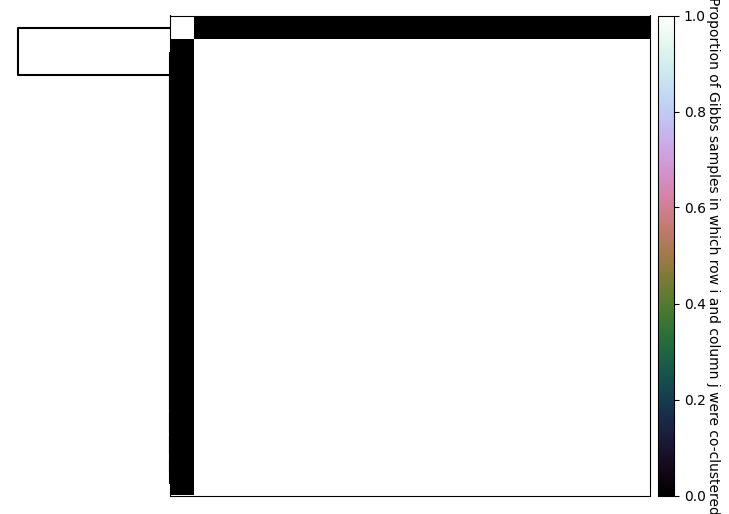

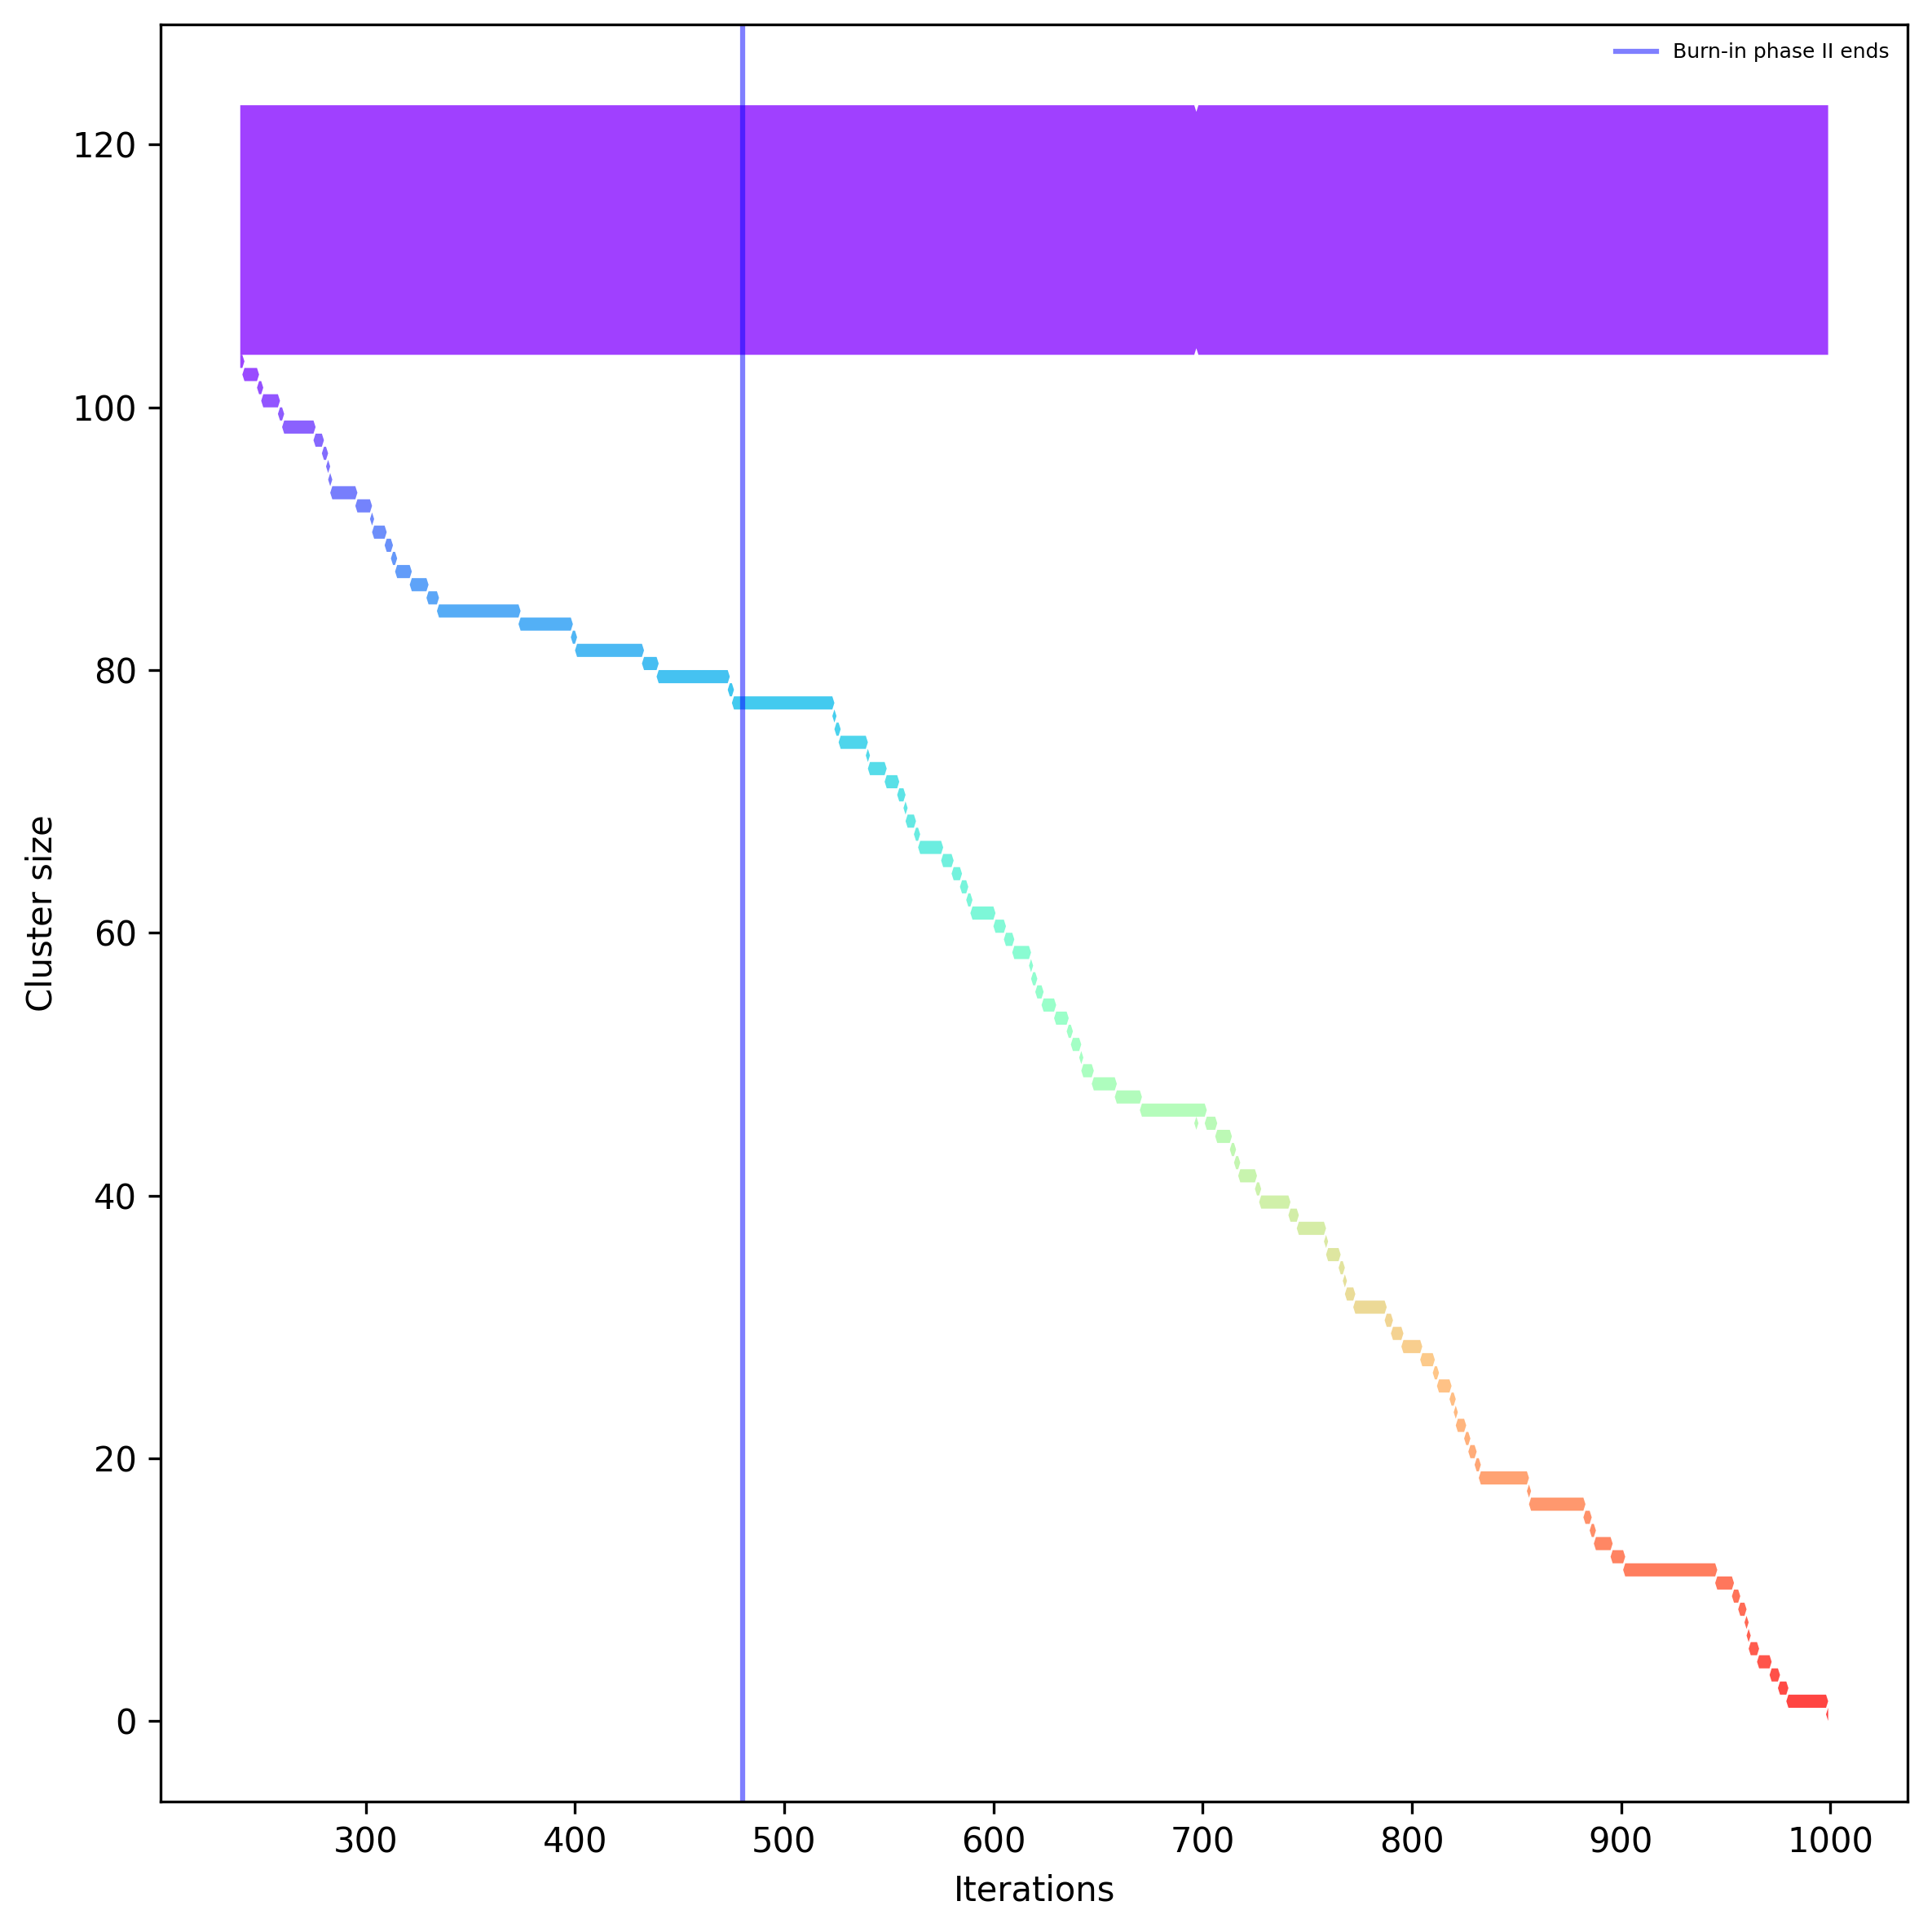

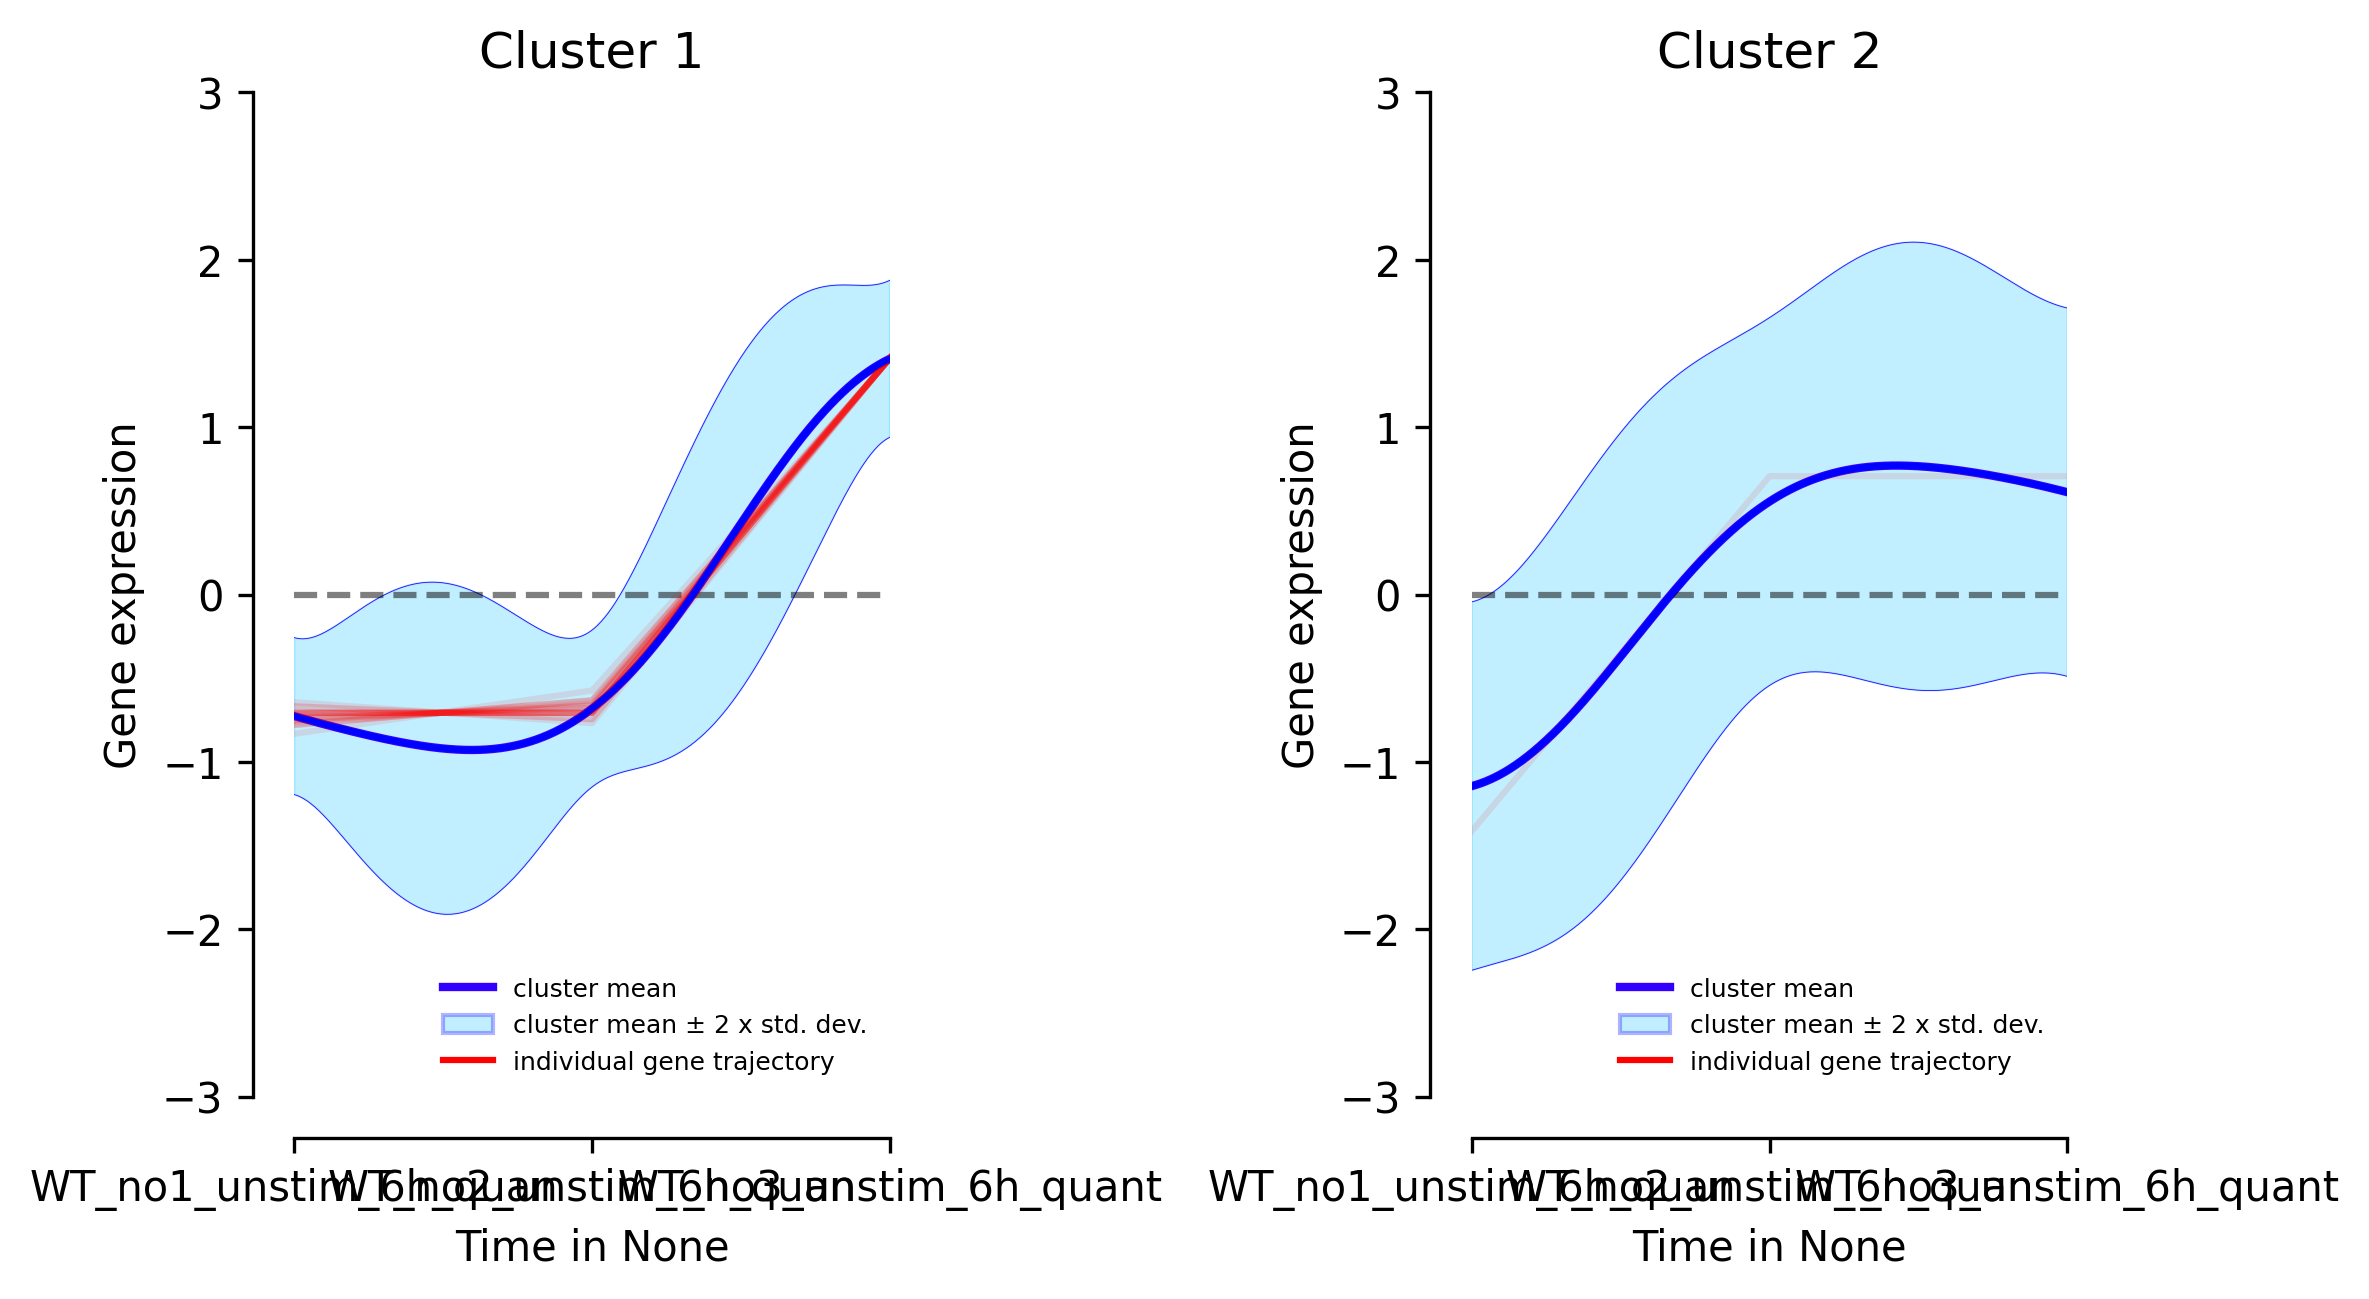

In [13]:
if plot:
    print("Plotting expression and sampling results.")    
    plot_types = plot_types
    if not post_process or sim_mat and not do_not_plot_sim_mat:
        try:
            sim_mat_key = dp_plt.plot_similarity_matrix(
                sim_mat, output_path_prefix, plot_types
                )
        except RuntimeError:
            print("WARNING: skipping heatmap plot generation, too many dendrogram recursions for scipy to handle")
        
    if not post_process:    
        core.save_posterior_similarity_matrix_key(
            [gene_names[idx] for idx in sim_mat_key], 
            output_path_prefix
            )
        dp_plt.plot_cluster_sizes_over_iterations(
            np.array(all_clusterings), 
            burnIn_phaseI, 
            burnIn_phaseII, 
            m, 
            output_path_prefix, 
            plot_types
            )
    
    dp_plt.plot_cluster_gene_expression(
       optimal_clusters_GP,
       pd.DataFrame(
           gene_expression_matrix, index=gene_names, columns=t),
       t,
       t_labels,
       time_unit,
       output_path_prefix,
       plot_types, 
       unscaled,
       do_not_mean_center,
    )

## Save clusters

In [14]:
if save_cluster_GPs:    
    param_df = pd.DataFrame({name:dp_cluster.model.param_array for name, dp_cluster in optimal_clusters_GP.items()}) 
    param_df.index = dp_cluster.model.parameter_names()
    param_df.to_csv(output_path_prefix + "_cluster_model_params.txt", sep='\t', index=True, header=True)